In [1]:
NAME = "Julien Fer"
STUDENT_NUMBER = 10649441
EMAIL = "julien.fer88@gmail.com"

# Assignment 1: SIR Model (ODE)

In this assignment one learns to implement the SIR model without and with demography and one variant on this model. This is done for states of an epidemic and no epidemic. Below this cell one can find the different parts of the assignment

In [2]:
# import all the modules necessary for this assignment and set style for plots
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from math import ceil
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25

## Problem 1: Numerical integration of the basic model

### 1.1 Exercise 1.1

Numerically integrate the ODEs for states of an epidemic and no epidemic. What is the parameter that determines if the infectious disease will become an epidemic? Provide phase space diagrams, with analysis, of the system.

In [3]:
def basic_SIR(y, t, beta, gamma):
    """
    Representation of ODE of SIR
    """
    
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = -(dIdt + dSdt)
    
    return dSdt, dIdt, dRdt

def plot_dynamics(ax, func, init_pop, t, beta, gamma, state):
    """
    Plots the dynamics for a given SIR model, initial populaiton, beta and gamma
    """
    # gives solution of ODE over a certain time interval for a given population, beta and gamma
    sol = odeint(func, init_pop, t, args=(beta, gamma))

    # plot
    ax.plot(t, sol[:, 0] / N, 'b', label="Susceptibles")
    ax.plot(t, sol[:, 1] / N, 'y', label="Infected")
    ax.plot(t, sol[:, 2] / N, 'g', label="Recoverd")
    ax.legend(loc="best")
    ax.set_xlabel("Time / days", fontsize=12)
    ax.set_ylabel("Fraction of population", fontsize=12)
    ax.set_title(r"Basic SIR without demography" "\n" "({ep} state)".format(ep=state), fontsize=14)

def phase_plot(ax, func, t, beta, gamma, state):
    """
    Creates phase plot for a given SIR model, beta and gamma
    """
    
    # create vector for different initials values for infected
    I_step = 0.1 * N
    I_all = np.arange(I_step, N, I_step)
    I_all = np.insert(I_all, 0, 0.001 * N)

    # makes phase plot for the different initial values of infected
    for I_init in I_all:
        S_init = N - I_init - R0
        y0 = S_init, I_init, R0
        sol = odeint(func, y0, t, args=(beta, gamma))
        ax.plot(sol[:, 0] / N, sol[:, 1] / N, 'b-')
        ax.plot(sol[0,0] / N, sol[0,1] / N, 'ko')

    # create vector for different initials values for suceptibles
    # if there is an epidemic state make phase plot for the different inital values
    S_first = ceil(gamma / beta * 10) / 10
    if S_first < 1:
        S_step = 0.1 * N
        S_all = np.arange(S_first * N, N, S_step)
        S_all = np.insert(S_all, len(S_all), 0.999 * N)

        # makes phase plot for the different initial values of suceptibles
        # only for epidemic state
        I_init = 0.001 * N
        for S_init in S_all:
            R_init = N - S_init - I_init
            y0 = S_init, I_init, R_init
            sol = odeint(func, y0, t, args=(beta, gamma))
            ax.plot(sol[:, 0] / N, sol[:, 1] / N, 'b-')
            ax.plot(sol[0,0] / N, sol[0,1] / N, 'ko')
            
        # plot vertical line where gamma / beta
        ax.vlines(gamma / beta, 0.001, 1.05, colors='k', linestyles="dashed", linewidth=0.75)

    # creates diagonal line where R(0) = 0
    S_diagonal = [(N - I_init) / N for I_init in I_all]
    S_diagonal = np.array(S_diagonal[::-1])
    S_diagonal = np.insert(S_diagonal, 0, 0)
    I_diagonal = I_all[::-1] / N
    I_diagonal = np.insert(I_diagonal, 0, 1)
    ax.plot(S_diagonal, I_diagonal, 'k-')

    # creates horizontal line where I(0) = 0.001
    ax.hlines(0.001, 0, 1)
    
    # set limits axis and set title for axis and plot
    ax.set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))
    ax.set_xlabel("Fraction of Suceptibles (S)", fontsize=12)
    ax.set_ylabel("Fraction of Infected (I)", fontsize=12)
    ax.set_title(r"Basic SIR without demography phase plot" "\n" "({ep} state)".format(ep=state), fontsize=14)

    
def plot_SIR(func, init_pop, t, beta, gamma, state):
    """
    Plots the SIR model for a given initial population, 
    beta and gamma over a certain amounnt of time steps.
    Also plots the phaseplot.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_dynamics(axes[0], func, init_pop, t, beta, gamma, state)
    phase_plot(axes[1,], func, t, beta, gamma, state)
    plt.show()
    

Cell belows create plots for basic SIR model with epidemic state:

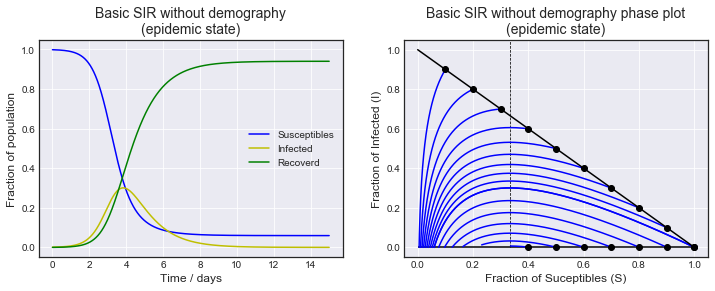

In [4]:
# total population, N.
N = 10000000

# initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 0.001 * N, 0

# everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# intials condition for y and solution of ODE
y0 = S0, I0, R0

# contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta_epidemic, gamma_epidemic = 3, 1

# a grid of time points (in days)
t = np.linspace(0, 15, 100000)

# make plots
plot_SIR(basic_SIR, y0, t, beta_epidemic, gamma_epidemic, "epidemic")

Cell belows plot basic SIR model with no epidemic state:

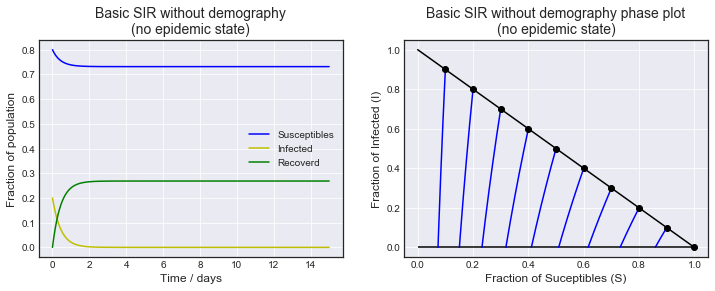

In [5]:
# initial number of infected and recovered individuals, I0 and R0.
I0_no_epidemic, R0_no_epidemic = 0.2 * N, 0

# everyone else, S0, is susceptible to infection initially.
S0_no_epidemic = N - I0_no_epidemic - R0_no_epidemic

# intials condition for y and solution of ODE
y0_no_epidemic = S0_no_epidemic, I0_no_epidemic, R0_no_epidemic

# contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta_no_epidemic, gamma_no_epidemic = 1, 3

plot_SIR(basic_SIR, y0_no_epidemic, t, beta_no_epidemic, gamma_no_epidemic, "no epidemic")

### 1.2 Exercise 1.2

Given below is the historical data from a case of an influenza outbreak situation. The outbreak was in a boys school with a total of 763 boys. It also seems that one infected boy started the epidemic. Could you try to fit an SIR model to the data?

| **Day**   | 1 | 2 |  3  |  4  |  5  |  6  |  7  |  8  |  9  | 10  | 11 | 12 | 13 | 14  |
| --------- |---|---| --- | --- | --- | --- | --- | --- | --- | --- | ---| ---| ---| --- |
| **Number**| 3 | 8 |  28 |  75 | 221 | 291 | 255 | 235 | 190 | 125 | 70 | 28 | 12 |  5  |

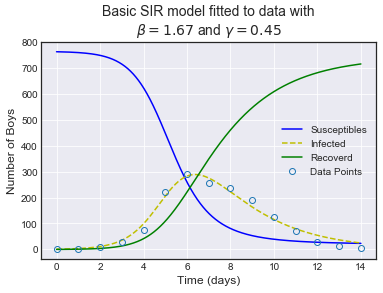

In [6]:
# set time interval (14 days) and the development of infected boys over the time interval
t_infected = np.linspace(0, 14, 15)
infected = np.array([1, 3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5])
t_ode = np.linspace(0, 14, 100000)

# total population, N.
N = 763

# initial number of infected and recovered individuals, I0 and R0.
I0, R0 = infected[0], 0

# everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# intials condition for y and solution of ODE
y0 = S0, I0, R0

# integrate given the inital population, returns the devlopment of infected 
def fit_odeint(x, beta, gamma):
    return odeint(basic_SIR, y0, x, args=(beta, gamma))[:,1]

par_opt, par_cov = curve_fit(fit_odeint, t_infected, infected)
fitted_infected = fit_odeint(t_infected, par_opt[0], par_opt[1])
fitted = odeint(basic_SIR, y0, t_ode, args=(par_opt[0], par_opt[1]))

# plot
plt.plot(t_ode, fitted[:, 0], 'b', label="Susceptibles")
plt.plot(t_ode, fitted[:, 1], "y--", label="Infected")
plt.plot(t_ode, fitted[:, 2], 'g', label="Recoverd")
plt.plot(t_infected, infected, 'o', mfc="none", label="Data Points")
plt.legend(loc="best")
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Number of Boys", fontsize=12)
plt.title(r"Basic SIR model fitted to data with" "\n" r"$\beta = {beta}$ and $\gamma = {gamma}$".format(beta=round(par_opt[0], 2), 
                                                                                                   gamma=round(par_opt[1], 2)), 
          fontsize=14)
plt.show()

### 1.3 Exercise 1.3

Can you propose a vaccination plan to prevent the epidemic?

An epidemic occurs when $S_{0}$ is larger than $\frac{1}{R_{0}}$. To prevent the epidemic from happening the vaccination plan should prevent S_{0} from being larger than $\frac{1}{R_{0}}$, resulting in the following equation:
\begin{equation*}
S_{0} < \frac{1}{R_{0}} = \frac{1}{3.755} \approx 0.266 = 26.6\%
\end{equation*}
To prevent the epidemic, at least least 73.4\% of the population should be vaccinated. For a school of 763 boys this means vaccinating at least 561 boys.

## Problem 2: Demography

Now we want to start to add more terms to our model. Lets start to consider demography i.e. Birth and death rates.

### 2.1 Excercise 1

Add birth and natural death rate term into model. (Hint: keep Npopulation constant). How does the dynamics change? Run the model to capture an endemic state. Do you see oscillatory behavior in the fraction of infected population? What are requirements to observe this behavior? What is the frequency and amplitude of these oscillations (Hint: use Fourier analysis)?

In [19]:
def demo_SIR(y, t, beta, gamma, mu):
    """
    Representation of ODE of SIR with demography
    i.e birth and death rates
    """
    
    S, I, R = y
    dSdt = mu - beta * S * I / N - mu * S
    dIdt = beta * S * I / N - gamma * I - mu * I
    dRdt = gamma * I - mu * R
    
    
    return dSdt, dIdt, dRdt

def plot_dyn_demo_SIR(ax, func, init_pop, t, beta, gamma, mu, state):
    """
    Plots the dynamics for a given SIR model, initial populaiton, beta and gamma
    """
    # gives solution of ODE over a certain time interval for a given population, beta and gamma
    sol = odeint(func, init_pop, t, args=(beta, gamma, mu))

    # plot
    ax.plot(t, sol[:, 0] / N, 'b', label="Susceptibles")
    ax.plot(t, sol[:, 1] / N, 'y', label="Infected")
    ax.plot(t, sol[:, 2] / N, 'g', label="Recoverd")
    ax.legend(loc="best")
    ax.set_xlabel("Time / days", fontsize=12)
    ax.set_ylabel("Fraction of population", fontsize=12)
    ax.set_title(r"SIR with demography" "\n" "({ep} state)".format(ep=state), fontsize=14)

def phase_plot_demo_SIR(ax, func, t, beta, gamma, mu, state):
    """
    Creates phase plot for a given SIR model, beta and gamma
    """
    
    # create vector for different initials values for infected
    I_step = 0.1 * N
    I_all = np.arange(I_step, N, I_step)
    I_all = np.insert(I_all, 0, 0.001 * N)

    # makes phase plot for the different initial values of infected
    for I_init in I_all:
        S_init = N - I_init - R0
        y0 = S_init, I_init, R0
        sol = odeint(func, y0, t, args=(beta, gamma, mu))
        ax.plot(sol[:, 0] / N, sol[:, 1] / N, 'b-')
        ax.plot(sol[0,0] / N, sol[0,1] / N, 'ko')

    # create vector for different initials values for suceptibles
    # if there is an epidemic state make phase plot for the different inital values
    S_first = ceil((gamma + mu) / beta * 10) / 10
    if S_first < 1:
        S_step = 0.1 * N
        S_all = np.arange(S_first * N, N, S_step)
        S_all = np.insert(S_all, len(S_all), 0.999 * N)

        # makes phase plot for the different initial values of suceptibles
        # only for epidemic state
        I_init = 0.001 * N
        for S_init in S_all:
            R_init = N - S_init - I_init
            y0 = S_init, I_init, R_init
            sol = odeint(func, y0, t, args=(beta, gamma, mu))
            ax.plot(sol[:, 0] / N, sol[:, 1] / N, 'b-')
            ax.plot(sol[0,0] / N, sol[0,1] / N, 'ko')
            
        # plot vertical line where (gamma + mu) / beta
        ax.vlines((gamma + mu) / beta, 0.001, 1.05, colors='k', linestyles="dashed", linewidth=0.75)

    # creates diagonal line where R(0) = 0
    S_diagonal = [(N - I_init) / N for I_init in I_all]
    S_diagonal = np.array(S_diagonal[::-1])
    S_diagonal = np.insert(S_diagonal, 0, 0)
    I_diagonal = I_all[::-1] / N
    I_diagonal = np.insert(I_diagonal, 0, 1)
    ax.plot(S_diagonal, I_diagonal, 'k-')

    # creates horizontal line where I(0) = 0.001
    ax.hlines(0.001, 0, 1)
    
    # set limits axis and set title for axis and plot
    ax.set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))
    ax.set_xlabel("Fraction of Suceptibles (S)", fontsize=12)
    ax.set_ylabel("Fraction of Infected (I)", fontsize=12)
    ax.set_title(r"SIR with demography phase plot" "\n" "({ep} state)".format(ep=state), fontsize=14)

    
def plot_demo_SIR(func, init_pop, t, beta, gamma, mu, state):
    """
    Plots the SIR model for a given initial population, 
    beta and gamma over a certain amounnt of time steps.
    Also plots the phaseplot.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_dyn_demo_SIR(axes[0], func, init_pop, t, beta, gamma, mu, state)
    phase_plot_demo_SIR(axes[1,], func, t, beta, gamma, mu, state)
    plt.show()

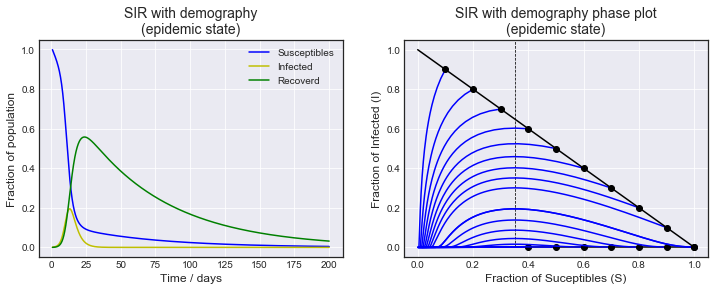

In [20]:
# total population, N.
N = 10000000

# initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 0.001 * N, 0

# everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# intials condition for y and solution of ODE
y0 = S0, I0, R0

# set parameter mu = 1/ 60, i.e natural birth and death rate
mu_epidemic = 1 / 60
beta2 = 1
gamma2 = 1 / 3

t = np.linspace(1, 200, 1000)

# make plots
plot_demo_SIR(demo_SIR, y0, t, beta2, gamma2, mu_epidemic, "epidemic")